### **Q1. CONVOLUTION**

Input image shape: (301, 289, 4)


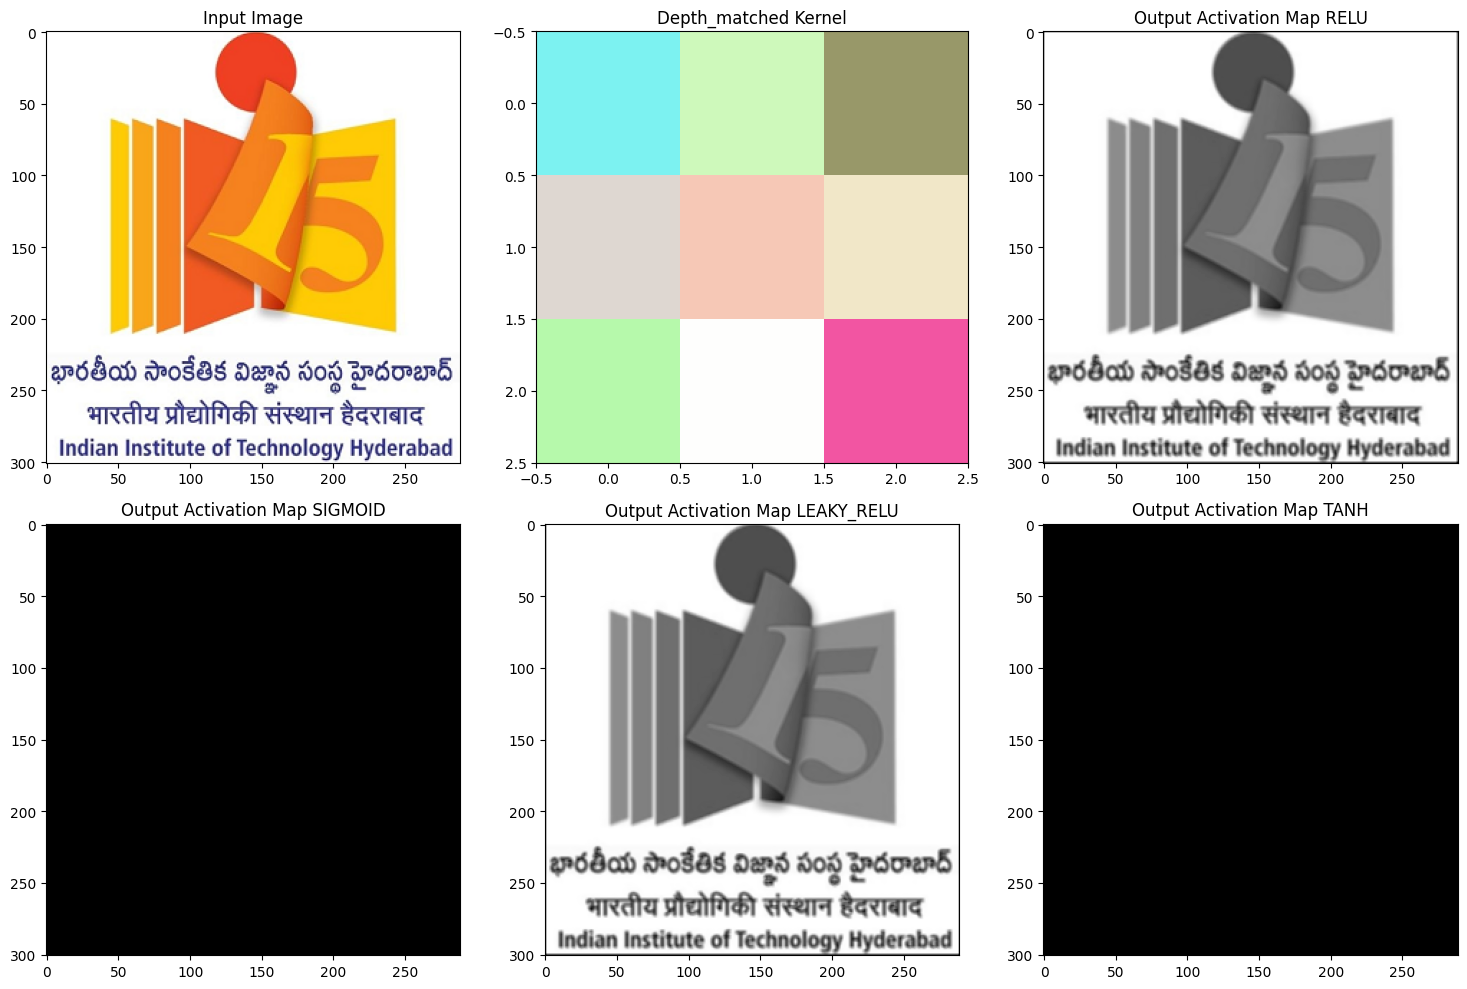

In [78]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO
import requests

def apply_padding(image, padding):
    if padding == 0:
        return image
    return np.pad(image, [(padding, padding), (padding, padding), (0, 0)], mode='constant', constant_values=0)

def convolve2d(image, kernel, stride, padding):
    image_padded = apply_padding(image, padding)
    kernel_height, kernel_width = kernel.shape[:2]
    output_height = ((image.shape[0] + 2 * padding - kernel_height) // stride) + 1
    output_width = ((image.shape[1] + 2 * padding - kernel_width) // stride) + 1

    # Ensure kernel has the same depth as the image for multi-channel images
    if image.ndim == 3 and kernel.ndim == 2:  # For grayscale kernels applied to color images
        kernel = np.expand_dims(kernel, axis=-1)
        kernel = np.repeat(kernel, image.shape[-1], axis=-1)

    output = np.zeros((output_height, output_width))
      # Iterate over each channel
    for y in range(0, output_height):
        for x in range(0, output_width):
            for z in range(image.shape[2]):
            # Correctly apply kernel to each channel
                output[y, x] += np.sum(image_padded[y*stride:y*stride+kernel_height, x*stride:x*stride+kernel_width, z] * kernel[:, :, z])
    return output

def non_linear_activation(x, function='relu'):
    if function == 'sigmoid':
        return 1 / (1 + np.exp(-x))
    elif function == 'tanh':
        return np.tanh(x)
    elif function == 'relu':
        return np.maximum(0, x)
    elif function == 'leaky_relu':
        return np.where(x > 0, x, x * 0.01)
    else:
        raise ValueError("Unsupported activation function.")

def convolution(image, kernel, stride, padding, non_linear_fn):
    output = convolve2d(image, kernel, stride, padding)
    output = non_linear_activation(output, non_linear_fn)
    return output

# Example usage
# Fetch the image from the URL
response = requests.get("https://cip.iith.ac.in/images/iith.png")
if response.status_code == 200:
    # Open the image using PIL
    image = Image.open(BytesIO(response.content))
    input_image = np.array(image)
    print("Input image shape:", input_image.shape)

    if input_image.ndim == 2:  # For grayscale images
        input_image = np.expand_dims(input_image, axis=-1)
    depth_matched_kernel = np.random.rand(3, 3, input_image.shape[2])
    output_activation_relu = convolution(input_image, depth_matched_kernel, stride=1, padding=1, non_linear_fn='relu')
    output_activation_sigmoid = convolution(input_image, depth_matched_kernel, stride=1, padding=1, non_linear_fn='sigmoid')
    output_activation_leaky_relu = convolution(input_image, depth_matched_kernel, stride=1, padding=1, non_linear_fn='leaky_relu')
    output_activation_tanh = convolution(input_image, depth_matched_kernel, stride=1, padding=1, non_linear_fn='tanh')

    fig, axs = plt.subplots(2, 3, figsize=(15, 10))

    # Plot the input image
    axs[0, 0].imshow(input_image.squeeze())
    axs[0, 0].set_title("Input Image")

    # Plot the depth_matched Kernel
    axs[0, 1].imshow(depth_matched_kernel[:, :, :], cmap='gray')
    axs[0, 1].set_title("Depth_matched Kernel")

    # Plot the output Activation Map RELU
    axs[0, 2].imshow(output_activation_relu.squeeze(), cmap='gray')
    axs[0, 2].set_title("Output Activation Map RELU")

    # Plot the output Activation Map SIGMOID
    axs[1, 0].imshow(output_activation_sigmoid.squeeze(), cmap='gray')
    axs[1, 0].set_title("Output Activation Map SIGMOID")

    # Plot the output Activation Map LEAKY_RELU
    axs[1, 1].imshow(output_activation_leaky_relu.squeeze(), cmap='gray')
    axs[1, 1].set_title("Output Activation Map LEAKY_RELU")

    # Plot the output Activation Map TANH
    axs[1, 2].imshow(output_activation_tanh.squeeze(), cmap='gray')
    axs[1, 2].set_title("Output Activation Map TANH")

    # Adjust layout
    plt.tight_layout()

    # Show the plot
    plt.show()

else:
    print("Failed to fetch the image.")


# **POOLING**

In [79]:
def pool2d(input_map, pool_size, stride, pooling_type='max'):

    # Calculate output dimensions
    output_height = ((input_map.shape[0] - pool_size) // stride) + 1
    output_width = ((input_map.shape[1] - pool_size) // stride) + 1
    # output_depth = input_map.shape[2]

    # Initialize the output activation map
    output = np.zeros((output_height, output_width))

      # Iterate over each channel
    for y in range(0, output_height):
        for x in range(0, output_width):
            region = input_map[y*stride:y*stride+pool_size, x*stride:x*stride+pool_size]
            if pooling_type == 'max':
                output[y, x] = np.max(region)
            elif pooling_type == 'avg':
                output[y, x] = np.mean(region)
            else:
                raise ValueError("Unsupported pooling type. Use 'max' or 'avg'.")

    return output

Input image shape: (301, 289, 4)


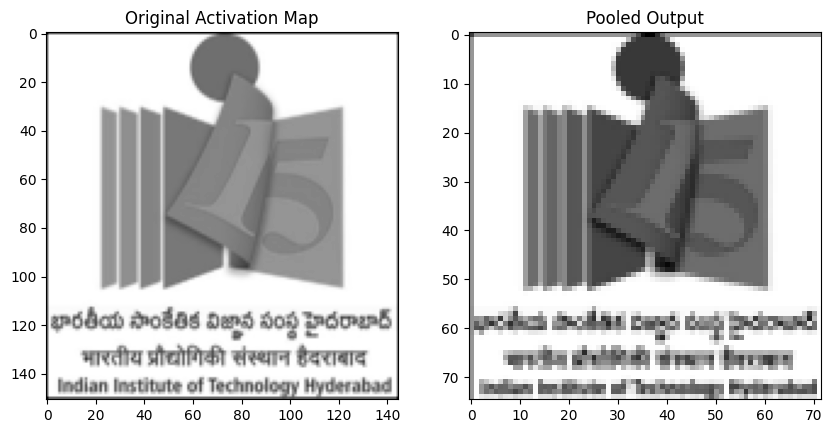

In [80]:
# Example usage
# Fetch the image from the URL
response = requests.get("https://cip.iith.ac.in/images/iith.png")
if response.status_code == 200:
    # Open the image using PIL
    image = Image.open(BytesIO(response.content))
    input_image = np.array(image)
    print("Input image shape:", input_image.shape)

    if input_image.ndim == 2:  # For grayscale images
        input_image = np.expand_dims(input_image, axis=-1)
    depth_matched_kernel = np.random.rand(3, 3, input_image.shape[2])
    output_activation = convolution(input_image, depth_matched_kernel, stride=2, padding=1, non_linear_fn='relu')
pool_size = 2  # Pooling window size
stride = 2  # Stride
pooling_type = 'avg'  # Pooling type: 'max' or 'avg'

# Apply pooling
pooled_output = pool2d(output_activation, pool_size, stride, pooling_type)

# Visualization
import matplotlib.pyplot as plt

# Display the original activation map
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(output_activation[:, :], cmap='gray')  # Assuming single-channel for visualization
plt.title("Original Activation Map")

# Display the pooled output
plt.subplot(1, 2, 2)
plt.imshow(pooled_output[:, :], cmap='gray')  # Assuming single-channel for visualization
plt.title("Pooled Output")
plt.show()

# **Q3 . convolution layer function**

In [81]:
import numpy as np

def conv_layer(input_volume, num_filters, kernel_size, stride, padding, non_linear_fn):

    input_depth = input_volume.shape[2]
    filter_height, filter_width = kernel_size
    filters = np.random.randn(num_filters, filter_height, filter_width, input_depth)  # Initialize filters

    # Apply padding
    input_padded = np.pad(input_volume, [(padding, padding), (padding, padding), (0, 0)], mode='constant', constant_values=0)

    # Calculate output dimensions
    output_height = int((input_volume.shape[0] - filter_height + 2 * padding) / stride) + 1
    output_width = int((input_volume.shape[1] - filter_width + 2 * padding) / stride) + 1

    # Initialize the output activation volume
    output_volume = np.zeros((output_height, output_width, num_filters))

    # Convolve each filter with the input volume
    for f in range(num_filters):
        current_filter = filters[f, :, :, :]
        for y in range(output_height):
            for x in range(output_width):
                for z in range(input_depth):
                    output_volume[y, x, f] += np.sum(input_padded[y*stride:y*stride+filter_height, x*stride:x*stride+filter_width, z] * current_filter[:, :, z])

    # Apply non-linear activation function
    if non_linear_fn == 'relu':
        output_volume = np.maximum(0, output_volume)
    elif non_linear_fn == 'sigmoid':
        output_volume = 1 / (1 + np.exp(-output_volume))
    elif non_linear_fn == 'tanh':
        output_volume = np.tanh(output_volume)
    elif non_linear_fn == 'leaky_relu':
        output_volume = np.where(output_volume > 0, output_volume, output_volume * 0.01)

    return output_volume, filters


In [82]:
import matplotlib.pyplot as plt

def display_results(input_volume, filters, output_volume):
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))

    # Display input volume
    ax[0].imshow(input_volume[:, :, :])
    ax[0].set_title('Input Volume')

    # Display filter kernels (first filter)
    ax[1].imshow(filters[0, :, :, :], cmap='gray')
    ax[1].set_title('First Filter Kernel')

    plt.show()

    figure, axes = plt.subplots(1, filters.shape[0] , figsize=(20, 5))
    for i in range(filters.shape[0]):
        axes[i].imshow(output_volume[ :, :, i], cmap='gray')
        axes[i].set_title(f'output channel {i+1}')
        axes[i].axis('off')

    plt.show()



    # plt.imshow(output_volume)  # Use squeeze() to handle single-channel images correctly
    # plt.title("output_volume Image")
    # plt.show()




Input image shape: (301, 289, 4)


Output Volume Shape: (303, 291, 4)


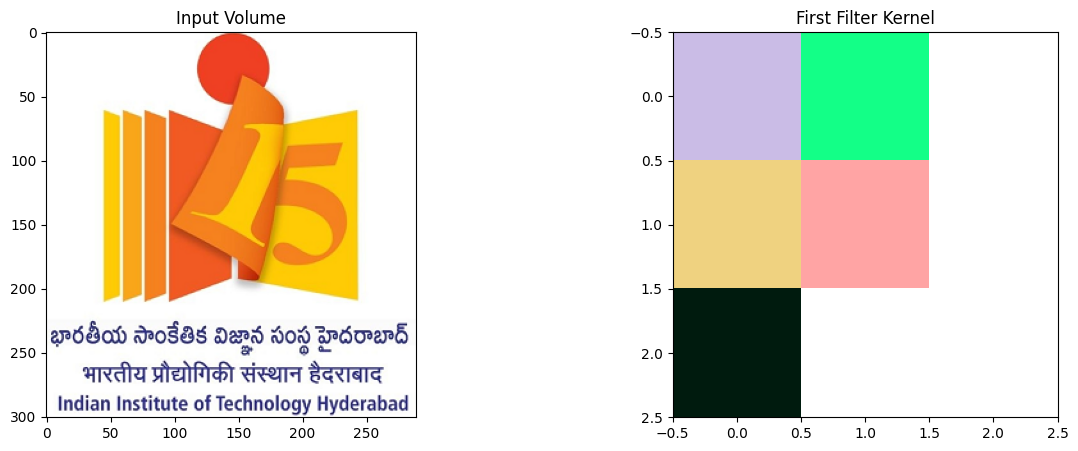

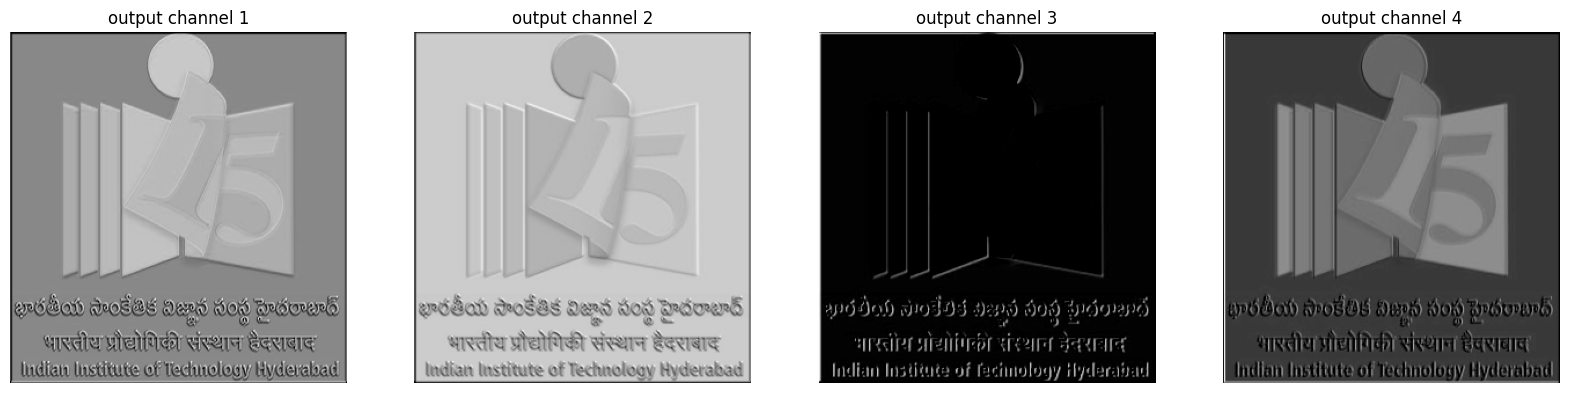

In [83]:
response = requests.get("https://cip.iith.ac.in/images/iith.png")
if response.status_code == 200:
    # Open the image using PIL
    image = Image.open(BytesIO(response.content))
    input_image = np.array(image)
    print("Input image shape:", input_image.shape)

    if input_image.ndim == 2:  # For grayscale images
        input_image = np.expand_dims(input_image, axis=-1)

    output_volume , filters = conv_layer(input_image, 4, (3,3) , 1, 2, 'relu')
    print(f"Output Volume Shape: {output_volume.shape}")
    display_results(input_image, filters, output_volume)

*Verification:*

output_activation_height = input_height - kernel_height + 2*padding) // stride + 1

output_activation_height = (301 - 3 + 2*2) // 1 + 1 = 303

output_activation_width = input_width - kernel_width + 2*padding) // stride + 1

output_activation_width = (289 - 3 + 2*2) // 1 + 1 = 291

depth = num_filters = 3

# **Q4. POOLING LAYER**

In [84]:
def pooling_layer(input_volume, pool_size, stride, pooling_type='max', global_pooling=False):

    if global_pooling:
        # For Global Average Pooling, pool_size and stride are determined by the input dimensions.
        pool_size = (input_volume.shape[0], input_volume.shape[1])
        stride = pool_size[0]  # Ensures single-window coverage of the entire input volume.
        pooling_type = 'avg'  # Global pooling is typically average pooling.

    input_height, input_width, num_channels = input_volume.shape
    # Calculate output dimensions
    output_height = int((input_height - pool_size[0]) / stride) + 1
    output_width = int((input_width - pool_size[1]) / stride) + 1

    # Initialize the output volume
    pooled_volume = np.zeros((output_height, output_width, num_channels))

    for channel in range(num_channels):
        for h in range(output_height):
            for w in range(output_width):
                h_start = h * stride
                h_end = h_start + pool_size[0]
                w_start = w * stride
                w_end = w_start + pool_size[1]

                pool_region = input_volume[h_start:h_end, w_start:w_end, channel]

                if pooling_type == 'max':
                    pooled_volume[h, w, channel] = np.max(pool_region)
                elif pooling_type == 'avg':
                    pooled_volume[h, w, channel] = np.mean(pool_region)
                else:
                    raise ValueError("Unsupported pooling type. Use 'max' or 'avg'.")

    return pooled_volume

Input image shape: (301, 289, 4)
shape of image after pooling (299, 287, 4)
shape of image after global average pooling (1, 1, 4)


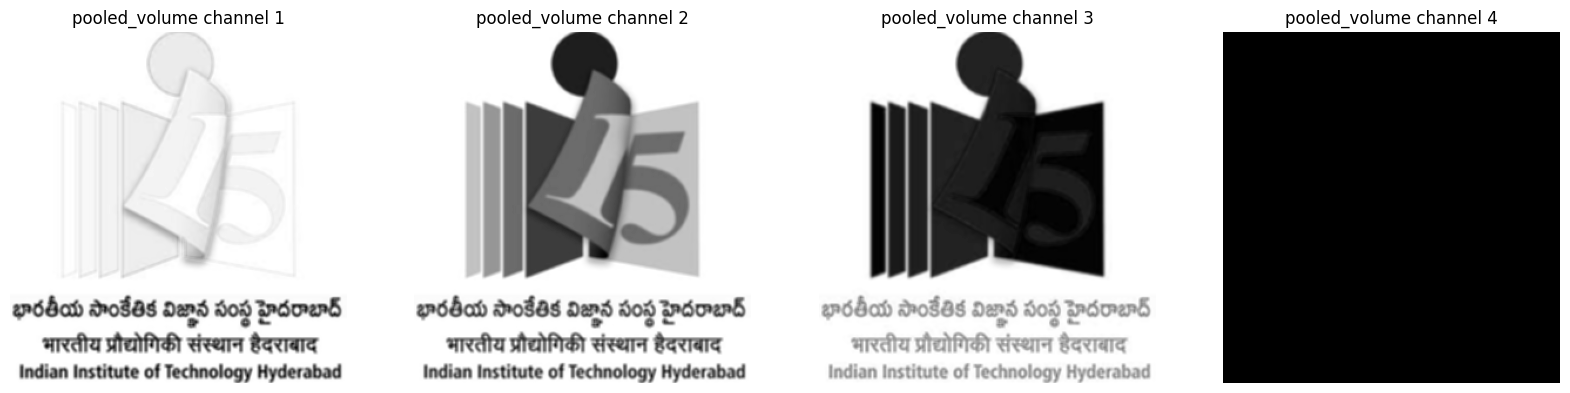

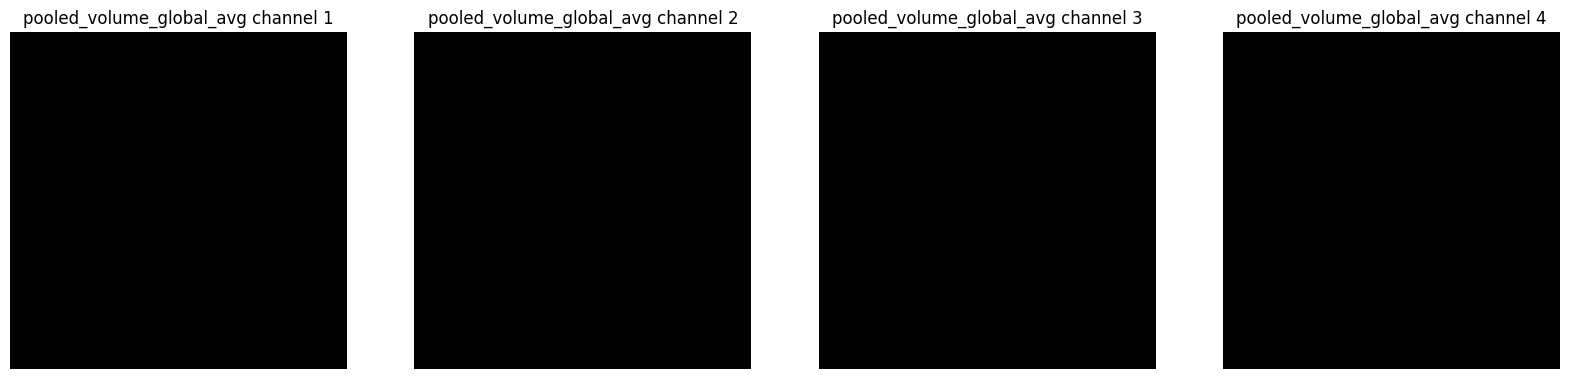

In [85]:
response = requests.get("https://cip.iith.ac.in/images/iith.png")
if response.status_code == 200:
    # Open the image using PIL
    image = Image.open(BytesIO(response.content))
    input_image = np.array(image)
    print("Input image shape:", input_image.shape)
    if input_image.ndim == 2:  # For grayscale images
        input_image = np.expand_dims(input_image, axis=-1)
pooled_volume = pooling_layer(input_image, (3,3), 1, pooling_type='avg', global_pooling=False)
print("shape of image after pooling", pooled_volume.shape)

pooled_volume_global_avg = pooling_layer(input_image, (3,3), 1, pooling_type='avg', global_pooling=True)
print("shape of image after global average pooling", pooled_volume_global_avg.shape)

figure, axes = plt.subplots(1, pooled_volume.shape[2] , figsize=(20, 5))
for i in range(pooled_volume.shape[2]):
    axes[i].imshow(pooled_volume[ :, :, i], cmap='gray')
    axes[i].set_title(f'pooled_volume channel {i+1}')
    axes[i].axis('off')
plt.show()

figure, axes = plt.subplots(1, pooled_volume_global_avg.shape[2] , figsize=(20, 5))
for i in range(pooled_volume_global_avg.shape[2]):
    axes[i].imshow(pooled_volume_global_avg[ :, :, i], cmap='gray')
    axes[i].set_title(f'pooled_volume_global_avg channel {i+1}')
    axes[i].axis('off')
plt.show()


# **Q5. MLP**

In [86]:
import numpy as np
from PIL import Image

def initialize_parameters(input_size, hidden_layers_sizes, output_size):
    """
    Initializes weights and biases for each layer in the network.
    """
    sizes = [input_size] + hidden_layers_sizes + [output_size]
    parameters = {}
    for i in range(1, len(sizes)):
        parameters[f'W{i}'] = np.random.randn(sizes[i], sizes[i-1]) * 0.01
        parameters[f'b{i}'] = np.zeros((sizes[i], 1))
    return parameters

def preprocess_image(image):
    """
    Flattens a 3D image into a 1D vector.
    """
    flattened_image = image.flatten().reshape(-1, 1)
    return flattened_image

def linear_activation_forward(A_prev, W, b, activation):
    Z = np.dot(W, A_prev) + b
    if activation == 'relu':
        A = np.maximum(0, Z)
    elif activation == 'sigmoid':
        A = 1 / (1 + np.exp(-Z))
    elif activation == 'tanh':
        A = np.tanh(Z)
    elif activation == 'linear':  # Assuming you want a linear activation
        A = Z  # Linear activation means no change to Z
    else:
        raise ValueError("Unsupported activation function.")
    return A

def softmax(x):
    """
    Compute softmax values for each set of scores in x.
    """
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

def mlp_forward(X, parameters, hidden_layers_activation_fn, output_activation_fn='softmax'):
    """
    Implements forward propagation for the MLP.
    """
    A = X
    L = len(parameters) // 2  # Number of layers in the MLP

    for l in range(1, L):
        A_prev = A
        A = linear_activation_forward(A_prev, parameters[f'W{l}'], parameters[f'b{l}'], activation=hidden_layers_activation_fn)

    ZL = np.dot(parameters[f'W{L}'], A) + parameters[f'b{L}']
    if output_activation_fn == 'softmax':
        AL = softmax(ZL)
    else:
        AL = linear_activation_forward(ZL, parameters[f'W{L}'], parameters[f'b{L}'], activation=output_activation_fn)
    return AL

# Load and preprocess the image
# Ensure you have an image at 'path/to/your/image.png'
response = requests.get("https://cip.iith.ac.in/images/iith.png")
if response.status_code == 200:
    # Open the image using PIL
    image = Image.open(BytesIO(response.content))
    input_image = np.array(image)
    print("Input image shape:", input_image.shape)

    if input_image.ndim == 2:  # For grayscale images
        input_image = np.expand_dims(input_image, axis=-1)
flattened_image = preprocess_image(input_image)

# Specify the MLP architecture
input_size = flattened_image.shape[0]
hidden_layers_sizes = [64, 32]  # Example sizes of hidden layers
output_size = 1000  # Example size of the output layer

# Initialize parameters
parameters = initialize_parameters(input_size, hidden_layers_sizes, output_size)

# Forward propagate through the MLP
output_softmax = mlp_forward(flattened_image, parameters, hidden_layers_activation_fn='relu')

# output_linear_activation
# output_linear = mlp_forward(flattened_image, parameters, hidden_layers_activation_fn='relu', output_activation_fn='linear')
# Print the output
# print("Output linear", output_linear)
print("output_softmax:", output_softmax.shape)


Input image shape: (301, 289, 4)
output_softmax: (1000, 1)


# **Q.6 - Putting-it all together**

# **for this we first need to upload the ILSVRC image to google colab**

In [87]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO


def apply_padding(image, padding):
    if padding == 0:
        return image
    return np.pad(image, [(padding, padding), (padding, padding), (0, 0)], mode='constant', constant_values=0)

def convolve2d(image, kernel, stride, padding):
    image_padded = apply_padding(image, padding)
    kernel_height, kernel_width = kernel.shape[:2]
    output_height = ((image.shape[0] + 2 * padding - kernel_height) // stride) + 1
    output_width = ((image.shape[1] + 2 * padding - kernel_width) // stride) + 1

    # Ensure kernel has the same depth as the image for multi-channel images
    if image.ndim == 3 and kernel.ndim == 2:  # For grayscale kernels applied to color images
        kernel = np.expand_dims(kernel, axis=-1)
        kernel = np.repeat(kernel, image.shape[-1], axis=-1)

    output = np.zeros((output_height, output_width))
      # Iterate over each channel
    for y in range(0, output_height):
        for x in range(0, output_width):
            for z in range(image.shape[2]):
            # Correctly apply kernel to each channel
                output[y, x] += np.sum(image_padded[y*stride:y*stride+kernel_height, x*stride:x*stride+kernel_width, z] * kernel[:, :, z])
    return output

def non_linear_activation(x, function='relu'):
    if function == 'sigmoid':
        return 1 / (1 + np.exp(-x))
    elif function == 'tanh':
        return np.tanh(x)
    elif function == 'relu':
        return np.maximum(0, x)
    elif function == 'leaky_relu':
        return np.where(x > 0, x, x * 0.01)
    else:
        raise ValueError("Unsupported activation function.")

def convolution(image, kernel, stride, padding, non_linear_fn):
    output = convolve2d(image, kernel, stride, padding)
    output = non_linear_activation(output, non_linear_fn)
    return output

def conv_layer(input_volume, num_filters, kernel_size, stride, padding, non_linear_fn):

    input_depth = input_volume.shape[2]
    filter_height, filter_width = kernel_size
    filters = np.random.randn(num_filters, filter_height, filter_width, input_depth)  # Initialize filters

    # Apply padding
    input_padded = np.pad(input_volume, [(padding, padding), (padding, padding), (0, 0)], mode='constant', constant_values=0)

    # Calculate output dimensions
    output_height = int((input_volume.shape[0] - filter_height + 2 * padding) / stride) + 1
    output_width = int((input_volume.shape[1] - filter_width + 2 * padding) / stride) + 1

    # Initialize the output activation volume
    output_volume = np.zeros((output_height, output_width, num_filters))

    # Convolve each filter with the input volume
    for f in range(num_filters):
        current_filter = filters[f, :, :, :]
        for y in range(output_height):
            for x in range(output_width):
                for z in range(input_depth):
                    output_volume[y, x, f] += np.sum(input_padded[y*stride:y*stride+filter_height, x*stride:x*stride+filter_width, z] * current_filter[:, :, z])

    # Apply non-linear activation function
    if non_linear_fn == 'relu':
        output_volume = np.maximum(0, output_volume)
    elif non_linear_fn == 'sigmoid':
        output_volume = 1 / (1 + np.exp(-output_volume))
    elif non_linear_fn == 'tanh':
        output_volume = np.tanh(output_volume)
    elif non_linear_fn == 'leaky_relu':
        output_volume = np.where(output_volume > 0, output_volume, output_volume * 0.01)

    return output_volume, filters

def pooling_layer(input_volume, pool_size, stride, pooling_type='max', global_pooling=False):

    if global_pooling:
        # For Global Average Pooling, pool_size and stride are determined by the input dimensions.
        pool_size = (input_volume.shape[0], input_volume.shape[1])
        stride = pool_size[0]  # Ensures single-window coverage of the entire input volume.
        pooling_type = 'avg'  # Global pooling is typically average pooling.

    input_height, input_width, num_channels = input_volume.shape
    # Calculate output dimensions
    output_height = int((input_height - pool_size[0]) / stride) + 1
    output_width = int((input_width - pool_size[1]) / stride) + 1

    # Initialize the output volume
    pooled_volume = np.zeros((output_height, output_width, num_channels))

    for channel in range(num_channels):
        for h in range(output_height):
            for w in range(output_width):
                h_start = h * stride
                h_end = h_start + pool_size[0]
                w_start = w * stride
                w_end = w_start + pool_size[1]

                pool_region = input_volume[h_start:h_end, w_start:w_end, channel]

                if pooling_type == 'max':
                    pooled_volume[h, w, channel] = np.max(pool_region)
                elif pooling_type == 'avg':
                    pooled_volume[h, w, channel] = np.mean(pool_region)
                else:
                    raise ValueError("Unsupported pooling type. Use 'max' or 'avg'.")

    return pooled_volume

def initialize_parameters(input_size, hidden_layers_sizes, output_size):
    """
    Initializes weights and biases for each layer in the network.
    """
    sizes = [input_size] + hidden_layers_sizes + [output_size]
    parameters = {}
    for i in range(1, len(sizes)):
        parameters[f'W{i}'] = np.random.randn(sizes[i], sizes[i-1]) * 0.01
        parameters[f'b{i}'] = np.zeros((sizes[i], 1))
    return parameters

def preprocess_image(image):
    """
    Flattens a 3D image into a 1D vector.
    """
    flattened_image = image.flatten().reshape(-1, 1)
    return flattened_image

def linear_activation_forward(A_prev, W, b, activation):
    """
    Implements the forward propagation for a single layer with a linear->activation step.
    """
    Z = np.dot(W, A_prev) + b
    if activation == 'relu':
        A = np.maximum(0, Z)
    elif activation == 'sigmoid':
        A = 1 / (1 + np.exp(-Z))
    elif activation == 'tanh':
        A = np.tanh(Z)
    else:
        raise ValueError("Unsupported activation function.")
    return A

def softmax(x):
    """
    Compute softmax values for each set of scores in x.
    """
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

def mlp_forward(X, parameters, hidden_layers_activation_fn, output_activation_fn='softmax'):
    """
    Implements forward propagation for the MLP.
    """
    A = X
    L = len(parameters) // 2  # Number of layers in the MLP

    for l in range(1, L):
        A_prev = A
        A = linear_activation_forward(A_prev, parameters[f'W{l}'], parameters[f'b{l}'], activation=hidden_layers_activation_fn)

    ZL = np.dot(parameters[f'W{L}'], A) + parameters[f'b{L}']
    if output_activation_fn == 'softmax':
        AL = softmax(ZL)
    else:
        AL = linear_activation_forward(ZL, parameters[f'W{L}'], parameters[f'b{L}'], activation=output_activation_fn)

    return AL


def cnn_forward(input_image):
    # Assuming the input_image is a NumPy array of shape (224, 224, 3)

    # Step 1: First Convolution Layer
    # conv_layer(input_volume, num_filters, kernel_size, stride, padding, non_linear_fn)
    conv1_output , _ = conv_layer(input_image, num_filters=16, kernel_size=(5, 5),
                                     stride=1, padding=2, non_linear_fn='relu')

    # Step 2: First Pooling Layer
    pool1_output = pooling_layer(conv1_output, pool_size=(2, 2), stride=2, pooling_type='max')

    # Step 3: Second Convolution Layer
    conv2_output , _ = conv_layer(pool1_output, num_filters=32, kernel_size=(3, 3),
                                     stride=1, padding=2, non_linear_fn='sigmoid')

    # Step 4: Second Pooling Layer
    pool2_output = pooling_layer(conv2_output, pool_size=(2, 2), stride=2, pooling_type='max')

    # Step 5: Global Average Pooling Layer
    # pooling_layer(pool2_output, pool_size = (2,2), stride = 1, pooling_type='max', global_pooling=Tue)
    gap_output = pooling_layer(pool2_output, pool_size = (2,2), stride = 1, pooling_type='max', global_pooling=True)
    # Step 6: MLP
    # Flatten the GAP output to fit the MLP input
    mlp_input = gap_output.flatten().reshape(-1, 1)
    input_size = mlp_input.shape[0]
    hidden_layers_sizes = [64, 32]  # Example sizes of hidden layers
    output_size = 1000  # Example size of the output layer

# Initialize parameters
    parameters = initialize_parameters(input_size, hidden_layers_sizes, output_size)


    # Assuming the MLP is designed to accept the flattened GAP output size as input size
    mlp_output = mlp_forward(mlp_input, parameters, hidden_layers_activation_fn='relu',
                             output_activation_fn='softmax')

    return mlp_output


image_path = '/content/resized_image_224x224.png'
image = Image.open(image_path)
image = image.convert('RGB')
input_image = np.array(image)

print("Shape of the input image:", input_image.shape)
mlp_output = cnn_forward(input_image)
print(mlp_output.shape)

Shape of the input image: (224, 224, 3)


<ipython-input-87-36b66b65ca54>:78: RuntimeWarning: overflow encountered in exp
  output_volume = 1 / (1 + np.exp(-output_volume))


(1000, 1)


# **Q.7.1 ELMAN**

In [88]:
import numpy as np

def generate_sample(min_length=5, max_length=50):
    length = np.random.randint(min_length, max_length)
    first_dimension = np.random.rand(length)
    second_dimension = np.zeros(length)

    # Mark two positions for the elements to be summed
    positions = np.random.choice(range(length), size=2, replace=False)
    second_dimension[positions] = 1

    # Calculate the label as the sum of the chosen positions
    label = np.sum(first_dimension[positions])

    # Combine the two dimensions
    sample = np.vstack((first_dimension, second_dimension)).T

    return sample, label

def generate_dataset(samples=5000, min_length=5, max_length=10):
    X, y = [], []
    for _ in range(samples):
        sample, label = generate_sample(min_length, max_length)
        X.append(sample)
        y.append(label)
    return X, y

# Generate the dataset
X, y = generate_dataset()

# Example of generated sample and label
print(f"Example Sample:\n{X[0]}\nLabel: {y[0]}")
print(f"Total samples generated: {len(X)}")

Example Sample:
[[0.2085849  0.        ]
 [0.19449242 0.        ]
 [0.97084534 0.        ]
 [0.15436618 0.        ]
 [0.56668135 1.        ]
 [0.33968116 1.        ]
 [0.73693626 0.        ]]
Label: 0.9063625055996312
Total samples generated: 5000


In [89]:
import torch
import numpy as np

class ElmanRNN:
    def __init__(self, input_size, hidden_size, output_size):
        self.hidden_size = hidden_size
        # Initialize parameters with gradients tracking
        self.W_hh = torch.randn(hidden_size, hidden_size, requires_grad=True)
        self.W_xh = torch.randn(input_size, hidden_size, requires_grad=True)
        self.W_ho = torch.randn(hidden_size, output_size, requires_grad=True)
        self.bias_h = torch.zeros(1, hidden_size, requires_grad=True)
        self.bias_o = torch.zeros(1, output_size, requires_grad=True)

    def forward(self, x):
        hidden = torch.zeros(1, self.hidden_size)
        outputs = []
        for i in range(x.size(1)):
            hidden = torch.tanh(x[:,i,:] @ self.W_xh + hidden @ self.W_hh + self.bias_h)
            output = hidden @ self.W_ho + self.bias_o
            outputs.append(output)
        outputs = torch.cat(outputs,dim=1)
        return outputs


model_elman = ElmanRNN(input_size=2, hidden_size=1, output_size=1)
mse_elman = []
X_train = X[:4000]
y_train = y[:4000]
learning_rate = 0.001
for epoch in range(20):
    total_loss = 0
    for i in range(len(X_train)):
        x_sample = torch.tensor(X[i], dtype=torch.float).unsqueeze(0)
        y_true = torch.tensor([y[i]])
        output = model_elman.forward(x_sample)
        output = torch.sum(output)
        loss = torch.mean((output - y_true) ** 2)
        # loss = torch.mean((output[:,-1] - y_true) ** 2)
        loss.backward()

        with torch.no_grad():
            model_elman.W_hh -= learning_rate * model_elman.W_hh.grad
            model_elman.W_xh -= learning_rate * model_elman.W_xh.grad
            model_elman.W_ho -= learning_rate * model_elman.W_ho.grad
            model_elman.bias_h -= learning_rate * model_elman.bias_h.grad
            model_elman.bias_o -= learning_rate * model_elman.bias_o.grad

            model_elman.W_hh.grad.zero_()
            model_elman.W_xh.grad.zero_()
            model_elman.W_ho.grad.zero_()
            model_elman.bias_h.grad.zero_()
            model_elman.bias_o.grad.zero_()

        total_loss += loss.item()
    print(f'Epoch {epoch+1}, Loss: {total_loss / len(X_train)}')
    mse_elman.append(total_loss / len(X_train))
mse_elman


Epoch 1, Loss: 0.23720056503311682
Epoch 2, Loss: 0.2036702925352337
Epoch 3, Loss: 0.195923134497816
Epoch 4, Loss: 0.18869384285624047
Epoch 5, Loss: 0.18214954775170802
Epoch 6, Loss: 0.17683633742351745
Epoch 7, Loss: 0.17165948006501527
Epoch 8, Loss: 0.16357534872672924
Epoch 9, Loss: 0.14644800733590146
Epoch 10, Loss: 0.11783528861188726
Epoch 11, Loss: 0.09285728448353243
Epoch 12, Loss: 0.07543963232091269
Epoch 13, Loss: 0.06152481716449461
Epoch 14, Loss: 0.049749588469644265
Epoch 15, Loss: 0.040045299110153774
Epoch 16, Loss: 0.03242464063174182
Epoch 17, Loss: 0.02665005714641214
Epoch 18, Loss: 0.02234074003836364
Epoch 19, Loss: 0.019122306307481914
Epoch 20, Loss: 0.016693747285868595


[0.23720056503311682,
 0.2036702925352337,
 0.195923134497816,
 0.18869384285624047,
 0.18214954775170802,
 0.17683633742351745,
 0.17165948006501527,
 0.16357534872672924,
 0.14644800733590146,
 0.11783528861188726,
 0.09285728448353243,
 0.07543963232091269,
 0.06152481716449461,
 0.049749588469644265,
 0.040045299110153774,
 0.03242464063174182,
 0.02665005714641214,
 0.02234074003836364,
 0.019122306307481914,
 0.016693747285868595]

# **7.2 LSTM**

In [90]:
import torch
import numpy as np

class LSTM:
    def __init__(self, input_size, hidden_size, output_size):
        self.hidden_size = hidden_size
        self.W_xf = torch.randn(input_size, hidden_size, requires_grad=True)
        self.W_hf = torch.randn(hidden_size, hidden_size, requires_grad=True)
        self.W_xi = torch.randn(input_size, hidden_size, requires_grad=True)
        self.W_hi = torch.randn(hidden_size, hidden_size, requires_grad=True)
        self.W_xc = torch.randn(input_size, hidden_size, requires_grad=True)
        self.W_hc = torch.randn(hidden_size, hidden_size, requires_grad=True)
        self.W_xo = torch.randn(input_size, hidden_size, requires_grad=True)
        self.W_ho = torch.randn(hidden_size, hidden_size, requires_grad=True)
        self.W_hy = torch.randn(hidden_size, output_size, requires_grad=True)
        self.bias_f = torch.zeros(1, hidden_size, requires_grad=True)
        self.bias_i = torch.zeros(1, hidden_size, requires_grad=True)
        self.bias_c = torch.zeros(1, hidden_size, requires_grad=True)
        self.bias_o = torch.zeros(1, hidden_size, requires_grad=True)
        self.bias_y = torch.zeros(1, output_size, requires_grad=True)

    def forward(self, x):
        h = torch.zeros(1, self.hidden_size)
        c = torch.zeros(1, self.hidden_size)
        outputs = []
        for j in range(x.size(1)):
            f = torch.sigmoid(x[:,j,:] @ self.W_xf + h @ self.W_hf + self.bias_f)
            i = torch.sigmoid(x[:,j,:] @ self.W_xi + h @ self.W_hi + self.bias_i)
            c_tilde = torch.tanh(x[:,j,:] @ self.W_xc + h @ self.W_hc + self.bias_c)
            c = f * c + i * c_tilde
            o = torch.sigmoid(x[:,j,:] @ self.W_xo + h @ self.W_ho + self.bias_o)
            h = o * torch.tanh(c)
            output = h @ self.W_hy + self.bias_y
            outputs.append(output)
        outputs = torch.cat(outputs,dim=1)
        return outputs

model_lstm = LSTM(input_size=2, hidden_size=1, output_size=1)

mse_lstm = []
X_train = X[:4000]
y_train = y[:4000]

learning_rate = 0.001
for epoch in range(20):
    total_loss = 0
    for i in range(len(X_train)):
        x_sample = torch.tensor(X_train[i], dtype=torch.float).unsqueeze(0)
        y_true = torch.tensor([y_train[i]])
        output = model_lstm.forward(x_sample)
        # print(output)
        output = torch.sum(output)
        loss = torch.mean((output - y_true) ** 2)
        loss.backward()

        with torch.no_grad():
            model_lstm.W_xf -= learning_rate * model_lstm.W_xf.grad
            model_lstm.W_hf -= learning_rate * model_lstm.W_hf.grad
            model_lstm.W_xi -= learning_rate * model_lstm.W_xi.grad
            model_lstm.W_hi -= learning_rate * model_lstm.W_hi.grad
            model_lstm.W_xc -= learning_rate * model_lstm.W_xc.grad
            model_lstm.W_hc -= learning_rate * model_lstm.W_hc.grad
            model_lstm.W_xo -= learning_rate * model_lstm.W_xo.grad
            model_lstm.W_ho -= learning_rate * model_lstm.W_ho.grad
            model_lstm.W_hy -= learning_rate * model_lstm.W_hy.grad
            model_lstm.bias_f -= learning_rate * model_lstm.bias_f.grad
            model_lstm.bias_i -= learning_rate * model_lstm.bias_i.grad
            model_lstm.bias_c -= learning_rate * model_lstm.bias_c.grad
            model_lstm.bias_o -= learning_rate * model_lstm.bias_o.grad
            model_lstm.bias_y -= learning_rate * model_lstm.bias_y.grad

            model_lstm.W_xf.grad.zero_()
            model_lstm.W_hf.grad.zero_()
            model_lstm.W_xi.grad.zero_()
            model_lstm.W_hi.grad.zero_()
            model_lstm.W_xc.grad.zero_()
            model_lstm.W_hc.grad.zero_()
            model_lstm.W_xo.grad.zero_()
            model_lstm.W_ho.grad.zero_()
            model_lstm.W_hy.grad.zero_()
            model_lstm.bias_f.grad.zero_()
            model_lstm.bias_i.grad.zero_()
            model_lstm.bias_c.grad.zero_()
            model_lstm.bias_o.grad.zero_()
            model_lstm.bias_y.grad.zero_()

        total_loss += loss.item()
    print(f'Epoch {epoch+1}, Loss: {total_loss / len(X_train)}')
    mse_lstm.append(total_loss / len(X_train))
mse_lstm


Epoch 1, Loss: 0.20836517724592046
Epoch 2, Loss: 0.17405293030265087
Epoch 3, Loss: 0.13994608557612181
Epoch 4, Loss: 0.11795621936381259
Epoch 5, Loss: 0.1057070750236222
Epoch 6, Loss: 0.09572527363600497
Epoch 7, Loss: 0.08645969492089559
Epoch 8, Loss: 0.07788023805550646
Epoch 9, Loss: 0.07015133429597097
Epoch 10, Loss: 0.063362570511557
Epoch 11, Loss: 0.05749382747454526
Epoch 12, Loss: 0.052453378537602194
Epoch 13, Loss: 0.04812217239280501
Epoch 14, Loss: 0.04438291260970269
Epoch 15, Loss: 0.041131735641985426
Epoch 16, Loss: 0.038281222406291934
Epoch 17, Loss: 0.03575941961262963
Epoch 18, Loss: 0.033508203883731776
Epoch 19, Loss: 0.031480841348895644
Epoch 20, Loss: 0.029640391522588985


[0.20836517724592046,
 0.17405293030265087,
 0.13994608557612181,
 0.11795621936381259,
 0.1057070750236222,
 0.09572527363600497,
 0.08645969492089559,
 0.07788023805550646,
 0.07015133429597097,
 0.063362570511557,
 0.05749382747454526,
 0.052453378537602194,
 0.04812217239280501,
 0.04438291260970269,
 0.041131735641985426,
 0.038281222406291934,
 0.03575941961262963,
 0.033508203883731776,
 0.031480841348895644,
 0.029640391522588985]

# **7.3 GRU**

In [91]:
import torch
import numpy as np

class GRU:
    def __init__(self, input_size, hidden_size, output_size):
        self.hidden_size = hidden_size
        self.W_xz = torch.randn(input_size, hidden_size, requires_grad=True)
        self.W_hz = torch.randn(hidden_size, hidden_size, requires_grad=True)
        self.W_xr = torch.randn(input_size, hidden_size, requires_grad=True)
        self.W_hr = torch.randn(hidden_size, hidden_size, requires_grad=True)
        self.W_xh = torch.randn(input_size, hidden_size, requires_grad=True)
        self.W_hh = torch.randn(hidden_size, hidden_size, requires_grad=True)
        self.W_hy = torch.randn(hidden_size, output_size, requires_grad=True)
        self.bias_z = torch.zeros(1, hidden_size, requires_grad=True)
        self.bias_r = torch.zeros(1, hidden_size, requires_grad=True)
        self.bias_h = torch.zeros(1, hidden_size, requires_grad=True)
        self.bias_y = torch.zeros(1, output_size, requires_grad=True)

    def forward(self, x):
        h = torch.zeros(1, self.hidden_size)
        outputs = []
        for j in range(x.size(1)):
            z = torch.sigmoid(x[:,j,:] @ self.W_xz + h @ self.W_hz + self.bias_z)
            r = torch.sigmoid(x[:,j,:] @ self.W_xr + h @ self.W_hr + self.bias_r)
            h_tilde = torch.tanh(x[:,j,:] @ self.W_xh + (r * h) @ self.W_hh + self.bias_h)
            h = (1 - z) * h + z * h_tilde
            output = h @ self.W_hy + self.bias_y
            outputs.append(output)
        outputs = torch.cat(outputs,dim=1)
        return outputs

model_gru = GRU(input_size=2, hidden_size=1, output_size=1)

learning_rate = 0.001
X_train = X[:4000]
y_train = y[:4000]
mse_gru = []
for epoch in range(20):
    total_loss = 0
    for i in range(len(X_train)):
        x_sample = torch.tensor(X_train[i], dtype=torch.float).unsqueeze(0)
        y_true = torch.tensor([y_train[i]])
        output = model_gru.forward(x_sample)
        output = torch.sum(output)
        loss = torch.mean((output - y_true) ** 2)
        # loss = torch.mean((output[:,-1] - y_true) ** 2)
        loss.backward()

        with torch.no_grad():
            model_gru.W_xz -= learning_rate * model_gru.W_xz.grad
            model_gru.W_hz -= learning_rate * model_gru.W_hz.grad
            model_gru.W_xr -= learning_rate * model_gru.W_xr.grad
            model_gru.W_hr -= learning_rate * model_gru.W_hr.grad
            model_gru.W_xh -= learning_rate * model_gru.W_xh.grad
            model_gru.W_hh -= learning_rate * model_gru.W_hh.grad
            model_gru.W_hy -= learning_rate * model_gru.W_hy.grad
            model_gru.bias_z -= learning_rate * model_gru.bias_z.grad
            model_gru.bias_r -= learning_rate * model_gru.bias_r.grad
            model_gru.bias_h -= learning_rate * model_gru.bias_h.grad
            model_gru.bias_y -= learning_rate * model_gru.bias_y.grad

            model_gru.W_xz.grad.zero_()
            model_gru.W_hz.grad.zero_()
            model_gru.W_xr.grad.zero_()
            model_gru.W_hr.grad.zero_()
            model_gru.W_xh.grad.zero_()
            model_gru.W_hh.grad.zero_()
            model_gru.W_hy.grad.zero_()
            model_gru.bias_z.grad.zero_()
            model_gru.bias_r.grad.zero_()
            model_gru.bias_h.grad.zero_()
            model_gru.bias_y.grad.zero_()

        total_loss += loss.item()
    print(f'Epoch {epoch+1}, Loss: {total_loss / len(X_train)}')
    mse_gru.append(total_loss / len(X_train))


Epoch 1, Loss: 0.1795707938382412
Epoch 2, Loss: 0.10859175702449128
Epoch 3, Loss: 0.08820093817521767
Epoch 4, Loss: 0.07535867940238919
Epoch 5, Loss: 0.06692767399561404
Epoch 6, Loss: 0.061185979246857
Epoch 7, Loss: 0.05714757024757014
Epoch 8, Loss: 0.05421727349942181
Epoch 9, Loss: 0.05202322270361288
Epoch 10, Loss: 0.05032823732425893
Epoch 11, Loss: 0.04897894836221616
Epoch 12, Loss: 0.04787459942873852
Epoch 13, Loss: 0.04694852936656619
Epoch 14, Loss: 0.04615552357245379
Epoch 15, Loss: 0.045464363268298724
Epoch 16, Loss: 0.04485304863903848
Epoch 17, Loss: 0.044305701746044215
Epoch 18, Loss: 0.04381039324151523
Epoch 19, Loss: 0.043358124503468536
Epoch 20, Loss: 0.042941818541192125


# **MSE FOR BASELINE TEST AND TRAIN**

In [92]:
y_test = y[4000:]
from sklearn.metrics import mean_squared_error

# Constant prediction for the baseline
baseline_prediction_train = np.ones_like(y_train)
baseline_prediction_test = np.ones_like(y_test)
# Calculate Mean Squared Error (MSE) for the baseline predictor on training data
mse_baseline_train = mean_squared_error(y_train, baseline_prediction_train)
mse_baseline_test = mean_squared_error(y_test, baseline_prediction_test)
print("MSE for Baseline Predictor on Training Data:", mse_baseline_train)
print("MSE for Baseline Predictor on Test Data:", mse_baseline_test)

MSE for Baseline Predictor on Training Data: 0.16885687209662942
MSE for Baseline Predictor on Test Data: 0.16997453144797836


# **PLOTTING MSE ON TRAINING DATA**

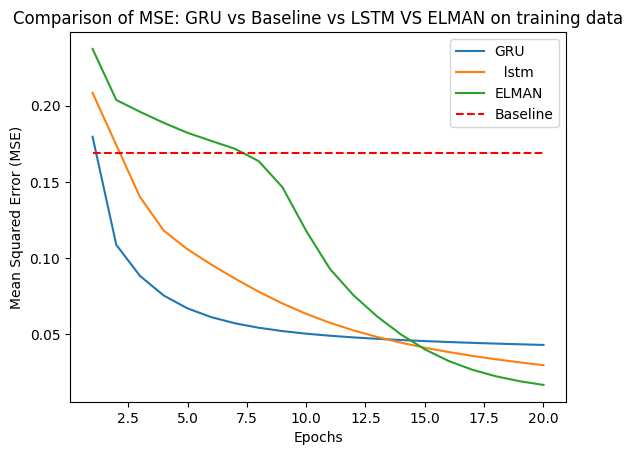

In [93]:
import matplotlib.pyplot as plt

epochs = range(1, 21)

# Plotting the MSE for GRU and Baseline Predictor
plt.plot(epochs, mse_gru, label='GRU')
plt.plot(epochs, mse_lstm, label='  lstm')
plt.plot(epochs, mse_elman, label='ELMAN')
plt.plot(epochs, [mse_baseline_train] * len(epochs), linestyle='--', color='r', label='Baseline')  # Straight line for baseline
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Comparison of MSE: GRU vs Baseline vs LSTM VS ELMAN on training data')
plt.legend()
plt.show()

# **PLOTTING MSE ON TEST DATA**

In [94]:
total_mse_gru = 0.0

X_test = X[4000:]
y_test = y[4000:]

# Process each sequence in the test set
for i, x_sequence in enumerate(X_test):
    # Convert sequence to tensor and ensure it has the correct shape [1, sequence_length, input_size]
    x_tensor = torch.tensor(x_sequence, dtype=torch.float).unsqueeze(0)

    # Perform a forward pass through the model
    with torch.no_grad():  # Ensure gradients are not computed for the test pass
        output = model_gru.forward(x_tensor)

    # Assuming the target is related to the output at the last timestep
    # print("output for index:", i ,output)
    # y_pred = output[:, -1]  # Get the last time step output
    y_pred = torch.sum(output)  # Get the last time step output
    y_true = torch.tensor([[y_test[i]]], dtype=torch.float)  # Ensure y_true has the correct shape

    # Compute the squared error
    mse = torch.mean((y_pred - y_true) ** 2).item()
    total_mse_gru += mse

# Calculate the average MSE over all test sequences
average_mse_gru = total_mse_gru / len(X_test)
print(f'Average MSE_gru on Test Data: {average_mse_gru}')



total_mse_lstm = 0.0

# Process each sequence in the test set
for i, x_sequence in enumerate(X_test):
    # Convert sequence to tensor and ensure it has the correct shape [1, sequence_length, input_size]
    x_tensor = torch.tensor(x_sequence, dtype=torch.float).unsqueeze(0)

    # Perform a forward pass through the model
    with torch.no_grad():  # Ensure gradients are not computed for the test pass
        output = model_lstm.forward(x_tensor)

    # Assuming the target is related to the output at the last timestep
    # print("output for index:", i ,output)
    # y_pred = output[:, -1]  # Get the last time step output
    y_pred = torch.sum(output)
    y_true = torch.tensor([[y_test[i]]], dtype=torch.float)  # Ensure y_true has the correct shape

    # Compute the squared error
    mse = torch.mean((y_pred - y_true) ** 2).item()
    total_mse_lstm += mse

# Calculate the average MSE over all test sequences
average_mse_lstm = total_mse_lstm / len(X_test)
print(f'Average MSE_lstm on Test Data: {average_mse_lstm}')


total_mse_elman = 0.0

# Process each sequence in the test set
for i, x_sequence in enumerate(X_test):
    # Convert sequence to tensor and ensure it has the correct shape [1, sequence_length, input_size]
    x_tensor = torch.tensor(x_sequence, dtype=torch.float).unsqueeze(0)

    # Perform a forward pass through the model
    with torch.no_grad():  # Ensure gradients are not computed for the test pass
        output = model_elman.forward(x_tensor)

    # Assuming the target is related to the output at the last timestep
    # print("output for index:", i ,output[:,-1])
    # y_pred = output[:, -1]  # Get the last time step output
    y_pred = torch.sum(output)
    y_true = torch.tensor([[y_test[i]]], dtype=torch.float)  # Ensure y_true has the correct shape

    # Compute the squared error
    mse = torch.mean((y_pred - y_true) ** 2).item()
    total_mse_elman += mse

# Calculate the average MSE over all test sequences
average_mse_elman = total_mse_elman / len(X_test)
print(f'Average MSE_elman on Test Data: {average_mse_elman}')

Average MSE_gru on Test Data: 0.035448982100178654
Average MSE_lstm on Test Data: 0.03097791986375347
Average MSE_elman on Test Data: 0.015515899269039792


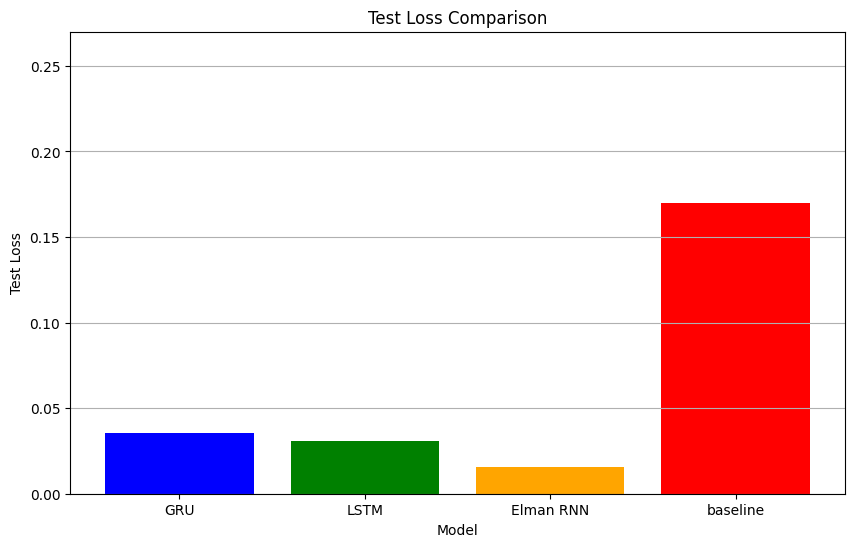

In [95]:
import matplotlib.pyplot as plt

models = ['GRU', 'LSTM', 'Elman RNN' , 'baseline']

# List to hold the corresponding test losses
test_losses = [average_mse_gru, average_mse_lstm, average_mse_elman , mse_baseline_test]

plt.figure(figsize=(10, 6))
plt.bar(models, test_losses, color=['blue', 'green', 'orange' , 'red'])
plt.title('Test Loss Comparison')
plt.xlabel('Model')
plt.ylabel('Test Loss')
plt.ylim(0, max(test_losses) + 0.1)  # Adjust ylim if needed
plt.grid(axis='y')
plt.show()